# 4.3. Transfer Learning

In [1]:
# importing the necessary packages/libraries
import numpy as np
from matplotlib import pyplot as plt
import random

import torch
import torch.nn as nn
import torchvision

import cv2
import glob
import ntpath
from skimage import io as ski_io

In [2]:
# Automatically selects GPU if available, else defaults to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import matplotlib.colors as mcolors

def generate_unique_rgb_colors(n_colors=70):
    """
    Generate a list of n unique visible RGB colors.

    Parameters:
        n_colors (int): The number of unique RGB colors to generate.

    Returns:
        List[Tuple[int, int, int]]: A list of RGB tuples with unique colors.
    """
    # Start with a large set of named colors from matplotlib
    color_names = list(mcolors.CSS4_COLORS.values())
    random.shuffle(color_names)  # Shuffle to ensure randomness

    # Convert named colors to RGB format (0-255 range)
    rgb_colors = [
        tuple(int(c * 255) for c in mcolors.to_rgb(color)) for color in color_names
    ]

    if n_colors <= len(rgb_colors):
        return rgb_colors[:n_colors]

    # If more colors are needed than available, generate additional ones
    additional_colors_needed = n_colors - len(rgb_colors)

    # Generate additional colors by sampling across the spectrum
    additional_colors = []
    for i in range(additional_colors_needed):
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)
        additional_colors.append((r, g, b))

    # Combine named colors with additional generated ones
    return rgb_colors + additional_colors[:additional_colors_needed]

In [4]:
labels = np.loadtxt('binary_shapes_db//binary_shapes_labels.txt', dtype=str)
labels = ['background', *labels]
print(len(labels))

11


In [5]:
# Mapping of labels to shape names
label_to_shape = {i: v for i, v in enumerate(labels)}

unique_label_colours = generate_unique_rgb_colors(len(label_to_shape)-1)
unique_label_colours = [(0, 0, 0), *unique_label_colours]

# Colours for visualisation (RGB values)
label_colours = {k: unique_label_colours[i] for i, k in enumerate(labels)}

In [6]:
def draw_random_object(background_img, fg_paths):
    # Generate a random colour for the foreground
    fg_colour = [np.random.randint(0, 256) for _ in range(3)]
    
    # Randomly choose a shape type (1: Circle, 2: Ellipse, 3: Rectangle)
    shape_type = np.random.randint(1, len(label_to_shape))
    fg_path = np.random.choice(fg_paths)
    fg_type = labels.index(ntpath.basename(fg_path).replace('.gif', '').split('-')[0])

    fg_img = ski_io.imread(fg_path)
    fg_size = background_img.shape[0] // 2
    fg_img = cv2.resize(fg_img, (fg_size, fg_size), interpolation=cv2.INTER_NEAREST)
    
    # Randomly position and size the shape
    pt = np.random.randint(0, fg_size, 2)
    for c in range(3):
        bg_chn = background_img[pt[0]:pt[0]+fg_size, pt[1]:pt[1]+fg_size, c]
        bg_chn[fg_img == 255] = fg_colour[c]
        background_img[pt[0]:pt[0]+fg_size, pt[1]:pt[1]+fg_size, c] = bg_chn

    # Generate ground truth mask (single-channel image)
    ground_truth = np.zeros(background_img.shape[:2], dtype=np.uint8)
    gt_tmp = ground_truth[pt[0]:pt[0]+fg_size, pt[1]:pt[1]+fg_size]
    gt_tmp[fg_img == 255] = fg_type
    ground_truth[pt[0]:pt[0]+fg_size, pt[1]:pt[1]+fg_size] = gt_tmp
    
    return background_img, ground_truth

In [7]:
def tile_image(background_img, fg_paths):
    height, width, _ = background_img.shape
    ground_truth = np.zeros((height, width), dtype=np.uint8)
    
    num_tiles = 2  # Number of tiles along each dimension
    tile_height = height // num_tiles
    tile_width = width // num_tiles
    
    for i in range(0, height, tile_height):
        for j in range(0, width, tile_width):
            tile = background_img[i:i + tile_height, j:j + tile_width]
            tile_with_shape, tile_mask = draw_random_object(tile, fg_paths)
            background_img[i:i + tile_height, j:j + tile_width] = tile_with_shape
            ground_truth[i:i + tile_height, j:j + tile_width] = tile_mask
    
    return background_img, ground_truth

In [8]:
def label_to_colour(mask):
    """
    Converts a label mask to a coloured image for visualisation.
    
    Args:
        mask (numpy.ndarray): Ground truth mask.
    
    Returns:
        numpy.ndarray: Coloured representation of the mask.
    """
    coloured_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for label in np.unique(mask):
        coloured_mask[mask == label] = label_colours[label_to_shape[label]]
    return coloured_mask

In [9]:
def random_crop(image, output_size):
    """
    Perform a random crop on the input image to produce an output image with the specified size.

    Args:
        image (numpy.ndarray): Input RGB image as a NumPy array (H x W x 3).
        output_size (tuple): Desired output size as (height, width).

    Returns:
        numpy.ndarray: Cropped RGB image with the specified size.
    """
    input_height, input_width, _ = image.shape
    output_height, output_width = output_size

    if output_height > input_height or output_width > input_width:
        raise ValueError("Output size must be smaller than or equal to the input image size.")

    # Randomly select the top-left corner for cropping
    top = random.randint(0, input_height - output_height)
    left = random.randint(0, input_width - output_width)

    # Perform the crop
    cropped_image = image[top:top + output_height, left:left + output_width]

    return cropped_image

In [10]:
# Custom PyTorch Dataset for Shape Images
class ShapeDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples, img_size, transform=None):
        """
        Initialise the dataset with the necessary parameters.

        Args:
            num_samples (int): Number of samples in the dataset.
            img_size (int): Size of the images (assumes square images).
            bg_type_probability (float): Probability of a uniform vs noisy background.
            transform (callable, optional): Transformations to apply to input images.
        """
        self.num_samples = num_samples
        self.img_size = img_size
        self.transform = transform
        bg_dir = 'bg_imgs/'
        fg_dir = 'binary_shapes_db/imgs/'
        self.bg_imgs = sorted(glob.glob(bg_dir + '*.*'))
        self.fg_imgs = sorted(glob.glob(fg_dir + '*.*'))[:(len(labels)-1)*20]

    def __len__(self):
        """Return the total number of samples."""
        return self.num_samples

    def __getitem__(self, index):
        """
        Generate a single data sample.

        Args:
            index (int): Sample index (not used here since samples are generated randomly).

        Returns:
            tuple: (input_image, ground_truth) where
                   input_image is a tensor of shape [C, H, W],
                   ground_truth is a tensor of shape [H, W].
        """
        # Randomly read one of the natural images for the background
        bg_img = cv2.imread(np.random.choice(self.bg_imgs))
        bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB)
        bg_img = random_crop(bg_img, (self.img_size, self.img_size))
        # Generate a random image and its ground truth
        image, ground_truth = tile_image(bg_img, self.fg_imgs)

        # Apply transformations to the input image
        if self.transform:
            image = self.transform(image)

        # Convert the ground truth to a PyTorch tensor (with long dtype for loss computation)
        ground_truth = torch.tensor(ground_truth, dtype=torch.long)
        return image, ground_truth

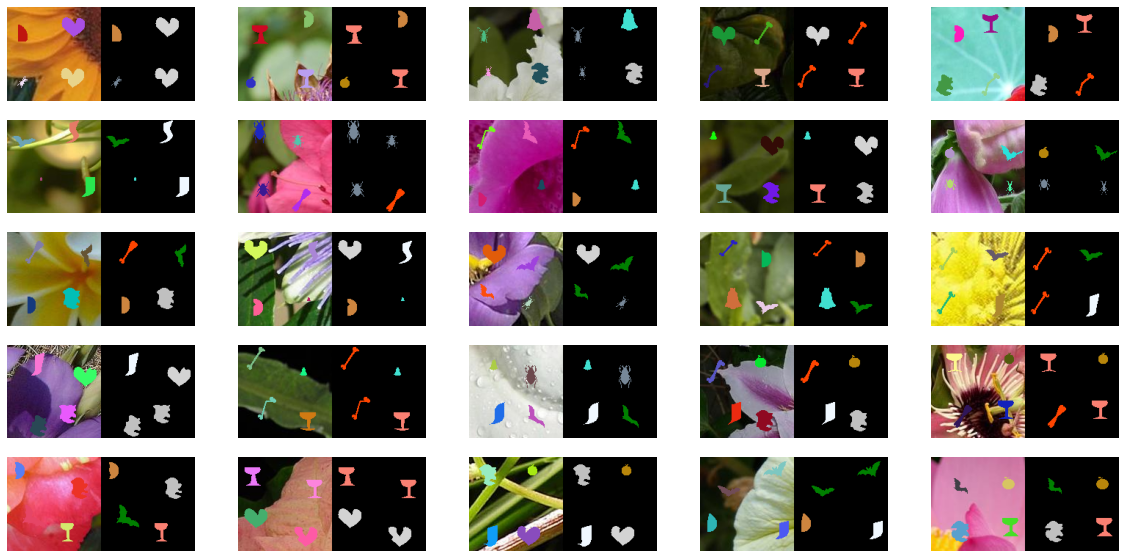

In [11]:
to_visualise_db = ShapeDataset(25, img_size=128)

# Generate and display 25 random examples

fig, ax = plt.subplots(5, 5, figsize=(20, 10))
for i in range(25):
    img, mask = to_visualise_db.__getitem__(i)
    ax[i // 5, i % 5].imshow(np.concatenate([img, label_to_colour(mask)], axis=1))
    ax[i // 5, i % 5].axis('off')
plt.show()

In [14]:
# Define the Simple CNN Model
class SimpleNet(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super().__init__()

        # Feature extraction block (encoder)
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # in=3, out=16
            nn.BatchNorm2d(16), # it must be the same as out of prvious layer
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # in=16 (it must be the same as out of previous layer)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # Upsampling block (decoder)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2), # 64 comes from the output of the self.features
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )

        # Classifier layer
        self.classifier = nn.Conv2d(16, num_classes, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Store the input size for final upsampling
        size = x.shape[-2:]
        # x shape is <B, 3, 128, 128>
        
        x = self.features(x)
        # x shape is <B, 64, 15, 15>
        
        x = self.decoder(x)
        # x shape is <B, 16, 63, 63>
        
        x = torch.nn.functional.interpolate(x, size=size, mode="bilinear", align_corners=False)
        # x shape is <B, 16, 128, 128>
        
        x = self.classifier(x)
        # x shape is <1, 16, 128, 128>
        return x

In [15]:
# Initialise the loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss().to(device)

In [16]:
def accuracy(output, target, ignore_label=0):
    """
    Computes pixel-wise accuracy, optionally ignoring specified labels.
    
    Args:
        output (torch.Tensor): Model predictions with shape <B, C, H, W>.
        target (torch.Tensor): Ground truth labels with shape <B, H, W>.
        ignore_label (int): Label to ignore in accuracy computation (default=0).

    Returns:
        torch.Tensor: Mean accuracy across all valid pixels.
    """
    # Ensure computations are performed without gradients for efficiency
    with torch.no_grad():
        # Convert predictions to class indices (highest probability for each pixel)
        predicted_classes = torch.argmax(output, dim=1)  # Shape: <B, H, W>
        
        # Compare predictions to ground truth labels
        correct_predictions = predicted_classes.eq(target)  # Shape: <B, H, W>
        
        # Exclude pixels with the ignored label
        valid_pixels = target != ignore_label  # Mask to filter out ignored pixels
        
        # Calculate the accuracy over valid pixels
        valid_correct_predictions = correct_predictions[valid_pixels]
        accuracy = valid_correct_predictions.float().mean()  # Compute mean accuracy
        
        return accuracy

In [17]:
def epoch_loop(model, db_loader, criterion, optimiser=None):
    """
    Run a single epoch for training or testing.
    
    Args:
        model (torch.nn.Module): The model to train/test.
        db_loader (DataLoader): Data loader for training or testing data.
        criterion (Loss Function): Loss function for computing the error.
        optimiser (torch.optim.Optimizer): Optimiser for training; if None, evaluation mode is assumed.
        
    Returns:
        accuracies (list): List of accuracies for each batch.
        losses (list): List of losses for each batch.
    """
    # Determine whether in training mode
    is_train = optimiser is not None
    model.train() if is_train else model.eval()
    
    accuracies = []
    losses = []
    
    # Disable gradient computation for evaluation
    with torch.set_grad_enabled(is_train):
        for batch_ind, (img, target) in enumerate(db_loader):
            # Move images and targets to device (GPU or CPU)
            img = img.to(device)
            target = target.to(device)
            
            # Forward pass: compute output and loss
            output = model(img)
            loss = criterion(output, target)
            losses.extend([loss.item() for _ in range(img.size(0))])

            # Compute accuracy
            acc = accuracy(output, target).cpu().numpy()
            accuracies.extend([acc for _ in range(img.size(0))])
            
            # Backward pass and optimisation step for training
            if is_train:
                optimiser.zero_grad()   # Reset gradients
                loss.backward()         # Backpropagate loss
                optimiser.step()        # Update parameters
    
    return accuracies, losses

In [18]:
# Dataset
num_train_samples = 1000
img_size = 128

# Set mean and standard deviation for normalisation
mean = 0.5
std = 0.25

# Compose transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),               # Convert to tensor
    torchvision.transforms.Normalize(mean, std),     # Normalise with mean and std
])

# Instantiate dataset for training
train_dataset = ShapeDataset(num_train_samples, img_size, transform=transform)

# Set batch size
batch_size = 8

# Create DataLoader for training
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=2, pin_memory=True, sampler=None
)

num_test_samples = 1000

# Instantiate dataset for validation
val_dataset = ShapeDataset(num_test_samples, img_size, transform=transform)

# Create DataLoader for validation
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=True, sampler=None
)


# Model
model = SimpleNet(len(label_to_shape)).to(device)
params_to_optimize = [{'params': [p for p in model.parameters()]}]
momentum = 0.9
learning_rate = 0.1
weight_decay = 1e-4
optimiser = torch.optim.SGD(
    params_to_optimize, lr=learning_rate,
    momentum=momentum, weight_decay=weight_decay
)

# Set the number of epochs for training
epochs = 10
initial_epoch = 0

# Logs for tracking accuracy and loss over time
train_logs = {'acc': [], 'loss': []}
val_logs = {'acc': [], 'loss': []}

for epoch in range(initial_epoch, epochs):
    # Run a training epoch
    train_log = epoch_loop(model, train_loader, criterion, optimiser)
    
    # Run a validation epoch (no optimiser, so the model is in evaluation mode)
    val_log = epoch_loop(model, val_loader, criterion, optimiser=None)
    
    # Print training and validation results for this epoch
    print('[Epoch %02d] Train loss=%.4f, acc=%.2f  |  Test loss=%.4f, acc=%.2f' % 
          (
              epoch, 
              np.mean(train_log[1]), np.mean(train_log[0]),
              np.mean(val_log[1]), np.mean(val_log[0])
          ))
    
    # Log the results for plotting later
    train_logs['acc'].append(np.mean(train_log[0]))
    train_logs['loss'].append(np.mean(train_log[1]))
    val_logs['acc'].append(np.mean(val_log[0]))
    val_logs['loss'].append(np.mean(val_log[1]))

[Epoch 00] Train loss=0.3476, acc=0.00  |  Test loss=0.2441, acc=0.00
[Epoch 01] Train loss=0.2077, acc=0.00  |  Test loss=0.2002, acc=0.00
[Epoch 02] Train loss=0.1864, acc=0.05  |  Test loss=0.1828, acc=0.12
[Epoch 03] Train loss=0.1804, acc=0.14  |  Test loss=0.1774, acc=0.16
[Epoch 04] Train loss=0.1742, acc=0.16  |  Test loss=0.1741, acc=0.15
[Epoch 05] Train loss=0.1686, acc=0.16  |  Test loss=0.1672, acc=0.16
[Epoch 06] Train loss=0.1638, acc=0.16  |  Test loss=0.1638, acc=0.18
[Epoch 07] Train loss=0.1538, acc=0.22  |  Test loss=0.1462, acc=0.23
[Epoch 08] Train loss=0.1462, acc=0.23  |  Test loss=0.1490, acc=0.26
[Epoch 09] Train loss=0.1325, acc=0.30  |  Test loss=0.1216, acc=0.40


In [21]:
## creating model
class TransferNet(nn.Module):
    def __init__(self, num_classes: int, fine_tune=False) -> None:
        super().__init__()

        pretrained = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(pretrained.children())[:7])
        for p in self.features.parameters():
            p.requires_grad = fine_tune
        # features_kernels is the number of kernels from our pretrained network.
        features_kernels = 256
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(features_kernels, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Conv2d(16, num_classes, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # storing the spatial resolution of input
        size = x.shape[-2:]
        # the input x is processed with the network
        x = self.features(x)
        x = self.decoder(x)
        x = torch.nn.functional.interpolate(x, size=size, mode="bilinear", align_corners=False)
        x = self.classifier(x)
        return x

In [25]:
# Dataset
num_train_samples = 1000
img_size = 128

# Instantiate dataset for training
train_dataset = ShapeDataset(num_train_samples, img_size, transform=transform)

# Set batch size
batch_size = 8

# Create DataLoader for training
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=2, pin_memory=True, sampler=None
)

num_test_samples = 1000

# Instantiate dataset for validation
val_dataset = ShapeDataset(num_test_samples, img_size, transform=transform)

# Create DataLoader for validation
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=True, sampler=None
)


# Model
model = TransferNet(len(label_to_shape), fine_tune=True).to(device)
params_to_optimize = [{'params': [p for p in model.parameters() if p.requires_grad]}]
momentum = 0.9
learning_rate = 0.1
weight_decay = 1e-4
optimiser = torch.optim.SGD(
    params_to_optimize, lr=learning_rate,
    momentum=momentum, weight_decay=weight_decay
)

# Set the number of epochs for training
epochs = 10
initial_epoch = 0

# Logs for tracking accuracy and loss over time
train_logs = {'acc': [], 'loss': []}
val_logs = {'acc': [], 'loss': []}

for epoch in range(initial_epoch, epochs):
    # Run a training epoch
    train_log = epoch_loop(model, train_loader, criterion, optimiser)
    
    # Run a validation epoch (no optimiser, so the model is in evaluation mode)
    val_log = epoch_loop(model, val_loader, criterion, optimiser=None)
    
    # Print training and validation results for this epoch
    print('[Epoch %02d] Train loss=%.4f, acc=%.2f  |  Test loss=%.4f, acc=%.2f' % 
          (
              epoch, 
              np.mean(train_log[1]), np.mean(train_log[0]),
              np.mean(val_log[1]), np.mean(val_log[0])
          ))
    
    # Log the results for plotting later
    train_logs['acc'].append(np.mean(train_log[0]))
    train_logs['loss'].append(np.mean(train_log[1]))
    val_logs['acc'].append(np.mean(val_log[0]))
    val_logs['loss'].append(np.mean(val_log[1]))

[Epoch 00] Train loss=0.2999, acc=0.00  |  Test loss=0.2178, acc=0.00
[Epoch 01] Train loss=0.2059, acc=0.00  |  Test loss=0.1962, acc=0.00
[Epoch 02] Train loss=0.1896, acc=0.08  |  Test loss=0.1852, acc=0.13
[Epoch 03] Train loss=0.1820, acc=0.14  |  Test loss=0.1768, acc=0.14
[Epoch 04] Train loss=0.1744, acc=0.15  |  Test loss=0.1615, acc=0.15
[Epoch 05] Train loss=0.1566, acc=0.19  |  Test loss=0.1439, acc=0.25
[Epoch 06] Train loss=0.1356, acc=0.31  |  Test loss=0.1211, acc=0.44
[Epoch 07] Train loss=0.1018, acc=0.55  |  Test loss=0.0868, acc=0.64
[Epoch 08] Train loss=0.0778, acc=0.66  |  Test loss=0.0706, acc=0.69
[Epoch 09] Train loss=0.0641, acc=0.72  |  Test loss=0.0583, acc=0.78


In [19]:
def visualise_batch_output(data_loader, max_imgs=4):
    # Iterate over the training data loader
    for batch_index, (images, ground_truth) in enumerate(data_loader):
        # Move the input images and ground truth labels to the device (e.g., GPU or CPU)
        images = images.to(device)
        ground_truth = ground_truth.to(device)
        
        # Forward pass: get model predictions for the batch of images
        predictions = model(images)
        break  # Exit after processing one batch for visualisation
    
    # Create a figure to display the input image, ground truth, and model output
    fig = plt.figure(figsize=(22, 8))

    ax_ind = 0
    for i in range(min(max_imgs, len(predictions))):
        # Display the input image
        ax_ind += 1
        ax = fig.add_subplot(2, max_imgs * 3 // 2, ax_ind)
        ax.axis('off')  # Remove axes for better visualisation
        # Transform image tensor back to RGB format and de-normalise it for visualisation
        ax.imshow(images[i].detach().cpu().numpy().transpose(1, 2, 0) * std + mean)
        ax.set_title('Input Image')
        
        # Display the ground truth labels as coloured segmentation
        ax_ind += 1
        ax = fig.add_subplot(2, max_imgs * 3 // 2, ax_ind)
        ax.axis('off')
        # Convert the ground truth labels to a colour map for better visualisation
        ax.imshow(label_to_colour(ground_truth[i].detach().cpu().numpy()))
        ax.set_title('Ground Truth')
        
        # Display the model's predicted segmentation
        ax_ind += 1
        ax = fig.add_subplot(2, max_imgs * 3 // 2, ax_ind)
        ax.axis('off')
        # Convert the predicted labels (argmax over channels) to a colour map
        ax.imshow(label_to_colour(torch.argmax(predictions[i], dim=0).detach().cpu().numpy()))
        ax.set_title('Model Output')
    
    # Show the plots
    plt.show()

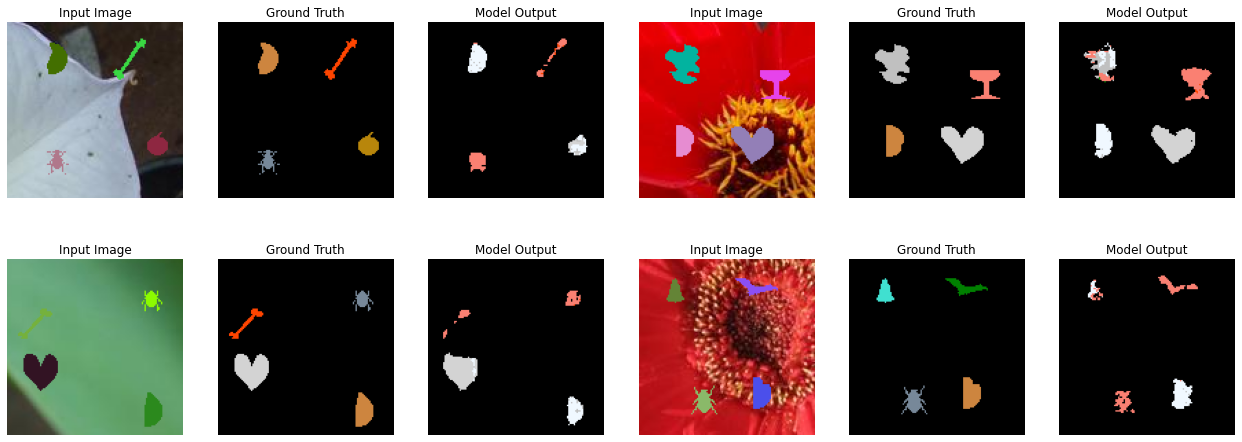

In [20]:
visualise_batch_output(val_loader)